# Set up the environment

In [1]:
# NOTE: after 'Restart runtime', installed packages are maintained!
!pip install transformers
!pip install tape_proteins # Takes a while
!pip install torchmetrics

!pip install pickle5
!pip install fastaparser

     |████████████████████████████████| 2.3MB 4.2MB/s 
     |████████████████████████████████| 3.3MB 48.7MB/s 
     |████████████████████████████████| 901kB 55.6MB/s 
     |████████████████████████████████| 71kB 3.6MB/s 
     |████████████████████████████████| 2.3MB 7.5MB/s 
     |████████████████████████████████| 753.4MB 22kB/s 
     |████████████████████████████████| 133kB 56.2MB/s 
     |████████████████████████████████| 122kB 58.4MB/s 
     |████████████████████████████████| 7.6MB 43.2MB/s 
     |████████████████████████████████| 81kB 11.7MB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.4.0 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.4.0 which is incompatible.
ERROR: botocore 1.20.93 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstal

In [2]:
import torch
import torch.nn as nn

import time
import numpy as np
import random
import csv
import os
import os.path
import pandas as pd
import math
import sys
import editdistance
import torchmetrics
import matplotlib.pyplot as plt

from torchmetrics import Accuracy, Precision, Recall, F1
from transformers import get_polynomial_decay_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
from tape import ProteinBertModel, TAPETokenizer

import pickle5 as pickle
import fastaparser, gzip, shutil

# Some helper methods
def format_time(t):
    return time.strftime('%H:%M:%S', time.gmtime(t))

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

# Returns the number of clusters and clusters as dict
def cluster(cdr3_list, cluster_identity=0.70): # cdr3_list = list of tuples (id, cdr3)
    os.system('wget https://drive5.com/downloads/usearch11.0.667_i86linux32.gz -O usearch.gz')
    with gzip.open('usearch.gz', 'rb') as f_in:
        with open('usearch', 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    os.remove('usearch.gz')
    os.system('chmod +rwx usearch') # Change access permission

    with open('cdr3.fasta', 'w') as fasta_file:
        writer = fastaparser.Writer(fasta_file)
        for seq_id, cdr3 in cdr3_list:
            writer.writefasta((seq_id, cdr3))

    os.mkdir(os.getcwd()+'/usearch_results')
    os.system(os.getcwd()+'/usearch -cluster_fast cdr3.fasta -id '+str(cluster_identity)+' -clusters usearch_results/nr.fasta')
    os.system(os.getcwd()+'/usearch -cluster_fast cdr3.fasta -id '+str(cluster_identity)+' -centroids centroids.fasta')
    
    res = dict(); count = 0
    with open('centroids.fasta') as fasta_file: # centroids
        parser = fastaparser.Reader(fasta_file)
        for i, seq in enumerate(parser):
            with open('usearch_results/nr.fasta'+str(i)) as fasta_file_cluster:
                parser_cluster = fastaparser.Reader(fasta_file_cluster)
                for cls_seq in parser_cluster:
                    res.setdefault(count,[]).append((cls_seq.id))
                count += 1
    
    shutil.rmtree(os.getcwd()+'/usearch_results', ignore_errors=True) # remove intermediate results
    os.remove('centroids.fasta')
    os.remove('cdr3.fasta')
    os.remove('usearch')
    return count, res

# Set random values to make it reproducible
seed_val = 0
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)

# Make sure that runtime type is GPU
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.    
    device = torch.device('cuda')
    torch.cuda.manual_seed_all(seed_val)
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0),'\n')
else:
    print('No GPU available, using the CPU instead.\n')
    device = torch.device('cpu')

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB 



# Create train and test dataset


## Load datasets

To summerize:

* ``` best_clusters_dict ```: mapping from cluster to centroid and containing ids
* ``` best_dict ```: mapping from ids of best neutralizing antibodies to all relevant information. Size: 68
* ``` broad-neutralizing_dict ```
* ``` non-neutralizing_dict ```
* ``` UZH_dataset_dict ```
* ``` simonich_dict ```

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
datasets_dir = '/content/drive/MyDrive/datasets/' # From where to load datasets. I used google drive.

best_clusters_dict = load_obj(datasets_dir+'best_clusters_dict')
best_dict = load_obj(datasets_dir+'best_dict')

broad_dict = load_obj(datasets_dir+'broad-neutralizing_dict')
non_dict = load_obj(datasets_dir+'non-neutralizing_dict')
UZH_dict = load_obj(datasets_dir+'UZH_dataset_dict')
simonich_dict = load_obj(datasets_dir+'simonich_dict')

# These are datasets for which the split based on the germline identity will be performed
ds_list = [('broad',broad_dict),('non',non_dict),('UZH',UZH_dict),('simonich',simonich_dict)]

## Split according to germline identity

In [5]:
# Split data sets into sequences below and above the v_j_identity_threshold
v_j_identity_threshold = 85

dicts_low = dict() # Used for training
dicts_high = dict()
for lab, d in ds_list:
    dicts_low[lab] = dict()
    dicts_high[lab] = dict()
    for k in d.keys():
        v_identity = float(d[k]['v_identity'])
        j_identity = float(d[k]['j_identity'])

        if (v_identity + j_identity)/2 < v_j_identity_threshold:
            dicts_low[lab][k] = d[k]
        else:
            dicts_high[lab][k] = d[k]
    print('{}\t | Number of sequences below v-j-identity threshold {} \t(total = {})'.format(lab,len(dicts_low[lab]),len(d)))

broad	 | Number of sequences below v-j-identity threshold 7579 	(total = 409622)
non	 | Number of sequences below v-j-identity threshold 1723 	(total = 384028)
UZH	 | Number of sequences below v-j-identity threshold 373 	(total = 12664)
simonich	 | Number of sequences below v-j-identity threshold 5 	(total = 202166)


## Reserve sequences for testing

In [6]:
test_sizes = {
    'low': {
        'broad': 500,
        'non': 300, # Notice that 14 will be used in the validation set
        'UZH': 100,
        'simonich': 5 # Not used during training
    },
    'high': {
        'broad': 10000,
        'non': 10000,
        'UZH': 10000,
        'simonich': 10000
    },
}
dicts_low_test = dict()
dicts_high_test = dict()
for lab, _ in ds_list:
    dicts_low_test[lab] = dict(list(dicts_low[lab].items())[:test_sizes['low'][lab]])
    dicts_low[lab] = dict(list(dicts_low[lab].items())[test_sizes['low'][lab]:])
 
    dicts_high_test[lab] = dict(list(dicts_high[lab].items())[:test_sizes['high'][lab]])
    dicts_high[lab]= dict(list(dicts_high[lab].items())[test_sizes['high'][lab]:])

## Visualize datasets

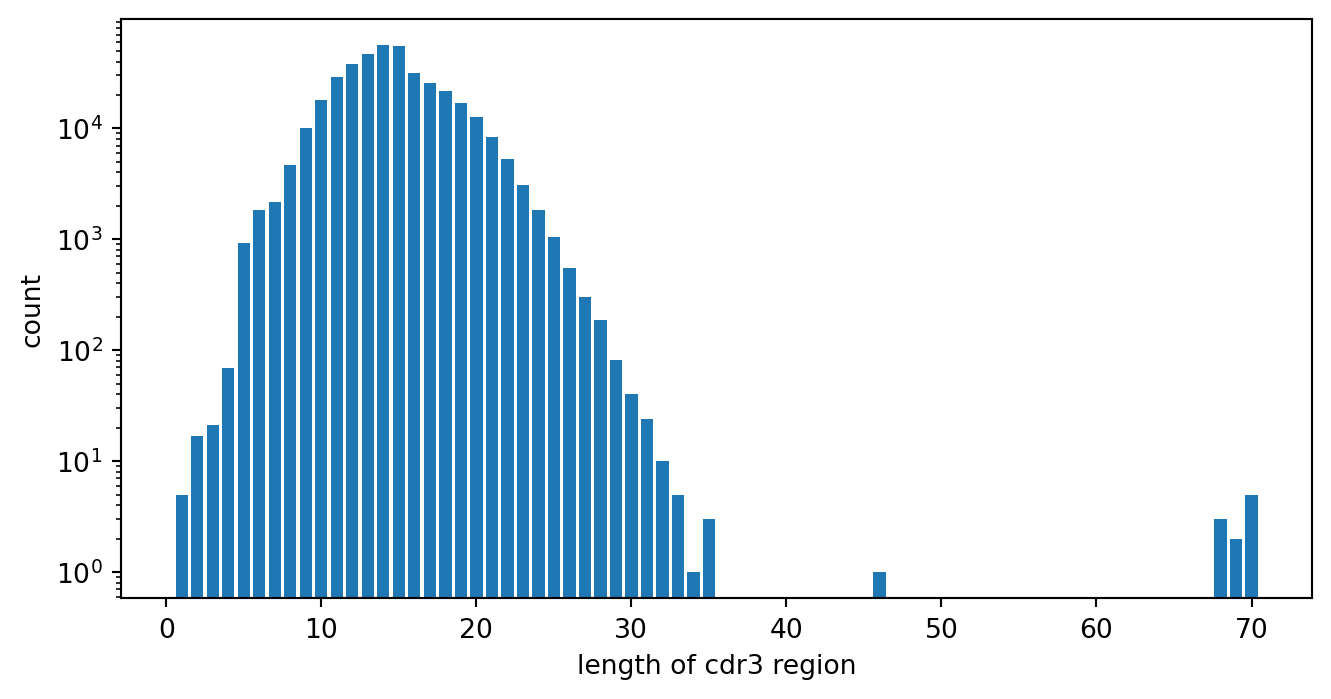

In [7]:
dpi = 96*2
plt.figure(figsize=(8,4),dpi=dpi)

dataset = 'broad'
dict_ = dicts_high

data = dict_[dataset]
x = [len(y['cdr3_aa']) for _,y in data.items()]
n_bins = max(x)-min(x)+1
n, bins = np.histogram(x, bins=n_bins)

plt.bar([min(x)+y for y in range(n_bins)],n,log=True)

plt.xlabel('length of cdr3 region')
plt.ylabel('count')
# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
# plt.savefig(destination_folder+'HISTOGRAM_'+dataset+'_.png',transparent=True,dpi=dpi,pad_inches=0.1,bbox_inches='tight')
plt.show()

## Define similarity functions

Guidelines:

* bnAbs training & testing as different as possible. First the sequence similarity should be as low as possible, then if possible different germline sequences. Similarity is defined as the weighted average of the cdr3 similarity and the germline similarity:

$$ sim_{id}(id_1,id_2):= \alpha\cdot sim(id_1.cdr3,id_2.cdr3)+(1-\alpha)\cdot sim(id_1.ger,id_2.ger) $$ 

$$ sim(a,b):= 1-\frac{edit\_distance(a,b)}{\max\{len(a),len(b)\}} $$ 

$$0\leq\alpha\leq 1$$

* labelled bnAbs & non-bnAbs sequences of the training set should be as similar as possible, i.e. same germeline sequences and ideally same CDRH3 length and sequence identity to germline

In [8]:
def similarity(key_a, key_b, dict_a, dict_b, alpha):
    cdr3_1 = dict_a[key_a]['cdr3_aa']
    cdr3_2 = dict_b[key_b]['cdr3_aa']
    ga_1 = dict_a[key_a]['germline_alignment_aa']
    ga_2 = dict_b[key_b]['germline_alignment_aa']
    sim_cdr3 = 1 - (editdistance.eval(cdr3_1, cdr3_2) / max(len(cdr3_1), len(cdr3_2)))
    sim_ga = 1 - (editdistance.eval(ga_1, ga_2) / max(len(ga_1), len(ga_2)))
    return alpha * sim_cdr3 + (1-alpha) * sim_ga

# Implemented as in the report
# most=False -> find LESS similar set
def find_most_similar(given_dict, search_dict, out_size, alpha, verbose=False, most=True):
    out_set = list(); round_robin = False
    search_keys = list(search_dict.keys())
    given_keys = list(given_dict.keys())
    random.shuffle(given_keys)
    random.shuffle(search_keys)
    interval_size_search = int(len(search_keys)/out_size)
    interval_size_given = int(len(given_keys)/out_size)
    if interval_size_given == 0:
        round_robin = True
    for i in range(out_size):
        if i < out_size - 1:
            search_keys_int = search_keys[interval_size_search*i:interval_size_search*(i+1)]
            given_keys_int = [given_keys[i%len(given_keys)]] if round_robin else given_keys[interval_size_given*i:interval_size_given*(i+1)]
        else: # last intervals take everything unseen
            search_keys_int = search_keys[interval_size_search*i:]
            given_keys_int = [given_keys[i%len(given_keys)]] if round_robin else given_keys[interval_size_given*i:]

        best_sim = sys.float_info.min if most else sys.float_info.max
        best_key = None
        for search_key in search_keys_int:
            curr_sim = 0
            for given_key in given_keys_int:
                curr_sim += similarity(given_key, search_key, given_dict, search_dict, alpha)
            curr_sim /= len(given_keys_int) # Average
            if most and curr_sim > best_sim:
                best_sim = curr_sim
                best_key = search_key
            elif not most and curr_sim < best_sim:
                best_sim = curr_sim
                best_key = search_key
        out_set.append(best_key)
        if verbose:
            sys.stdout.write('\rSearch progress: {0} %'.format(int(100*(i+1)/out_size)))
            sys.stdout.flush()
    if verbose:
        print('\n')
    return out_set

def check_similarity(keys_a, keys_b, dict_a, dict_b, alpha):
    max_sim = sys.float_info.min
    min_sim = sys.float_info.max
    cum_sim = 0
    for key_a in keys_a:
        for key_b in keys_b:
            sim = similarity(key_a, key_b, dict_a, dict_b, alpha)
            cum_sim += sim
            if sim > max_sim:
                max_sim = sim
            if sim < min_sim:
                min_sim = sim
    avg_sim = cum_sim/(len(keys_a)*len(keys_b))
    return avg_sim, min_sim, max_sim

## CREATE TRAINING DATA

1. Define parameters

In [9]:
train_ratio = 0.8
alpha = 0.3
file_name_train = 'TRAIN_SET_baseline+UZH_labeled_non'

UZH_train_size_lab = 100 # Number of UZH seqs. with high germ. id. destined for training

2. Labeled data

In [10]:
size_best = len(best_dict)
num_clusters = len(best_clusters_dict)

# Greedy algorithm to compute train set (i.e. set of clusters) for pos. instances ONLY based on similarity and train_ratio
# Start with first cluster and then in each step add cluster that on average is most similar to already added sequences
# Hopefully this results in very different train and test sets
# This is identical to find_most_similar adapted to clusters (best broad neutr.)
R = int(size_best * train_ratio); fst_cls = random.randint(0, num_clusters-1)
train_clusters = {fst_cls}
size_train_keys_best = len(best_clusters_dict[fst_cls]['set'])
remaining_clusters = set(range(0, num_clusters)).difference(train_clusters)
while size_train_keys_best < R:
    best_score = sys.float_info.min
    best_cluster = None
    for r_c in remaining_clusters:
        cum_cluster_score = 0
        num_compared_seqs = 0
        for t_c in train_clusters:
            for key_b_c in best_clusters_dict[t_c]['set']:
                for key_r_c in best_clusters_dict[r_c]['set']:

                    sim = similarity(key_b_c, key_r_c, best_dict, best_dict, alpha)

                    cum_cluster_score += sim
                    num_compared_seqs += 1
        
        cluster_score = cum_cluster_score / num_compared_seqs

        if cluster_score > best_score:
            best_cluster = r_c
            best_score = cluster_score
    
    size_train_keys_best += len(best_clusters_dict[best_cluster]['set'])
    train_clusters.add(best_cluster)
    remaining_clusters.remove(best_cluster)

test_clusters = remaining_clusters
size_test_keys_best = size_best - size_train_keys_best

assert(len(train_clusters)+len(test_clusters) == num_clusters)
print('Split of best-broad-neutr. seqs: (train, test) = ({}, {})\n'.format(size_train_keys_best,size_test_keys_best))

# Check similarity between positive instances of train and test set
train_keys_best = [y for x in train_clusters for y in best_clusters_dict[x]['set']]
test_keys_best = [y for x in test_clusters for y in best_clusters_dict[x]['set']]
assert(len(train_keys_best) == size_train_keys_best and len(test_keys_best) == size_test_keys_best)
avg_sim, min_sim, max_sim = check_similarity(train_keys_best, test_keys_best, best_dict, best_dict, alpha)
print('Similarity between positive instances of train and test set: max =',max_sim,', avg =',avg_sim,'\n')

# Compute set of keys for negative instances of train set (most similar to positives ones)
given_dict = {k:v for k,v in best_dict.items() if k in train_keys_best}
train_keys_non_lab = find_most_similar(given_dict, dicts_low['non'], size_train_keys_best, alpha)
# Check similarity between positive and negative instances of train set
avg_sim, min_sim, max_sim = check_similarity(train_keys_best, train_keys_non_lab, best_dict, dicts_low['non'], alpha)
print('Similarity between positive and negative instances of train set: min =',min_sim,', avg =',avg_sim,'\n')

# Add random UZH sequences with high germline identity
UZH_high_keys = list(dicts_high['UZH'].keys()).copy()
random.shuffle(UZH_high_keys)
train_keys_UZH_lab = UZH_high_keys[:min(len(UZH_high_keys),UZH_train_size_lab)]

Split of best-broad-neutr. seqs: (train, test) = (54, 14)

Similarity between positive instances of train and test set: max = 0.5244730679156909 , avg = 0.39617916348741355 

Similarity between positive and negative instances of train set: min = 0.22019230769230771 , avg = 0.4896866296258902 



3. Unlabeled data

In [11]:
# Remove those already used in labeled section
unused_keys_non = set(dicts_low['non'].keys()).difference(train_keys_non_lab)

# GAN-BERT paper says |U| = 100 * |L|
# size_unlab_goal = 100*2*size_train_keys_best

# Non-neutralizing sequences
train_keys_non_unlab = unused_keys_non
print('Number of non-neutr. sequences in train set (unlabeled) = {}'.format(len(train_keys_non_unlab)))

# UZH sequences
train_keys_UZH = dicts_low['UZH'].keys()
print('Number of UZH sequences in train set (unlabeled) = {}'.format(len(train_keys_UZH)))

# Broad-neutralizing sequences
train_keys_broad = dicts_low['broad'].keys()
print('Number of broad-neutr. sequences in train set = {}'.format(len(train_keys_broad)))

Number of non-neutr. sequences in train set (unlabeled) = 1369
Number of UZH sequences in train set (unlabeled) = 273
Number of broad-neutr. sequences in train set = 7079


4. Create csv file

In [12]:
u_l_ratio = (len(train_keys_non_unlab)+len(train_keys_UZH)+len(train_keys_broad))/(len(train_keys_best)+len(train_keys_non_lab)+len(train_keys_UZH_lab))
balance = int(math.log(u_l_ratio, 2)) # Indicates how often the labeled instances will be repeated in train set
print('Ratio between unlabeled and labeled data is {}'.format(u_l_ratio))
print('Labeled sequences will be repeated {} times'.format(balance))

with open(file_name_train+'.csv', mode='w') as csv_file:
    print('Creating file "{}"'.format(file_name_train+'.csv'))
    writer = csv.writer(csv_file, delimiter=',')
    writer.writerow(['seq-id', 'label', 'sequence', 'germline', 'label-mask'])

    # Add positive instances (with augmentation)
    for k in train_keys_best:
        sa = best_dict[k]['sequence_alignment_aa']
        ga = best_dict[k]['germline_alignment_aa']
        for i in range(balance):    
            writer.writerow([k, 1, sa, ga, 1])

    # Add negative instances (with augmentation)
    for k in train_keys_non_lab:
        sa = dicts_low['non'][k]['sequence_alignment_aa']
        ga = dicts_low['non'][k]['germline_alignment_aa']
        for i in range(balance):
            writer.writerow([k, 0, sa, ga, 1])
    
    # Add negative instances (with augmentation)
    for k in train_keys_UZH_lab:
        sa = dicts_high['UZH'][k]['sequence_alignment_aa']
        ga = dicts_high['UZH'][k]['germline_alignment_aa']
        for i in range(balance):
            writer.writerow([k, 0, sa, ga, 1])
    
    # Add unlabeled instances (broad)
    for k in train_keys_broad:
        sa = dicts_low['broad'][k]['sequence_alignment_aa']
        ga = dicts_low['broad'][k]['germline_alignment_aa']
        writer.writerow([k, 0, sa, ga, 0])
    
    # Add unlabeled instances (non)
    for k in train_keys_non_unlab:
        sa = dicts_low['non'][k]['sequence_alignment_aa']
        ga = dicts_low['non'][k]['germline_alignment_aa']
        writer.writerow([k, 0, sa, ga, 0])
    
    # Add UZH instances
    for k in train_keys_UZH:
        sa = dicts_low['UZH'][k]['sequence_alignment_aa']
        ga = dicts_low['UZH'][k]['germline_alignment_aa']
        writer.writerow([k, 0, sa, ga, 0])

Ratio between unlabeled and labeled data is 41.92788461538461
Labeled sequences will be repeated 5 times
Creating file "TRAIN_SET_baseline+UZH_labeled_non.csv"


## CREATE TESTING DATA

Define parameters for test set(s)

In [13]:
file_name_test = 'TEST_SET'
file_name_val = 'VALIDATION_SET'

# Ratio between postive and negative instances in baseline test set
test_pos_ratio = 1

# Should be the same as for training set
alpha = 0.3

# Size of other test sets
test_size = 1000 # sys.maxsize # if available

In [14]:
# Writer for validation set
csv_file_val = open(file_name_val+'.csv', mode='w')
writer_val = csv.writer(csv_file_val, delimiter=',')
writer_val.writerow(['seq-id', 'label', 'sequence', 'germline', 'label-mask'])

# Writer for test set
csv_file_test = open(file_name_test+'.csv', mode='w')
writer_test = csv.writer(csv_file_test, delimiter=',')
writer_test.writerow(['seq-id', 'label', 'sequence', 'germline', 'label-mask'])

43

###### Baseline

In [15]:
# Remove best keys used in training set:
train_keys = list(pd.read_csv(file_name_train+'.csv')['seq-id'])
train_keys_best = [x for x in train_keys if 'best' in x]

test_keys_best = [k for k in best_dict.keys() if k not in train_keys_best]

# Compute set of keys for negative instances of test set (most similar to positives ones)
given_dict = {k:v for k,v in best_dict.items() if k in test_keys_best}
test_keys_non = find_most_similar(given_dict, dicts_low_test['non'], int(len(test_keys_best)/test_pos_ratio), alpha)
# Check similarity between positive and negative instances of test set
avg_sim, min_sim, max_sim = check_similarity(test_keys_best, test_keys_non, best_dict, dicts_low_test['non'], alpha)
print('Similarity between positive and negative instances of test set: min =',min_sim,', avg =',avg_sim,'\n')

Similarity between positive and negative instances of test set: min = 0.5036662452591656 , avg = 0.6281056090938586 



In [16]:
# Add positive instances
for k in test_keys_best:
    sa = best_dict[k]['sequence_alignment_aa']
    ga = best_dict[k]['germline_alignment_aa']
    writer_val.writerow([k, 1, sa, ga, 1])
    writer_test.writerow([k, 1, sa, ga, 1])

# Add negative instances
for k in test_keys_non:
    sa = dicts_low_test['non'][k]['sequence_alignment_aa']
    ga = dicts_low_test['non'][k]['germline_alignment_aa']
    writer_val.writerow([k, 0, sa, ga, 1])
    writer_test.writerow([k, 0, sa, ga, 1])

# Remove non-broad-neutr. sequences from dicts_low_test
dicts_low_test['non'] = {k:v for k,v in dicts_low_test['non'].items() if k not in test_keys_non}

csv_file_val.close()

###### Others (below threshold)

In [17]:
for test,_ in ds_list:

    test_keys = list(dicts_low_test[test].keys())[:test_size]
    print('| {} | Number of test sequences: {}'.format(test,len(test_keys)))

    for k in test_keys:
        sa = dicts_low_test[test][k]['sequence_alignment_aa']
        ga = dicts_low_test[test][k]['germline_alignment_aa']
        writer_test.writerow([k+'_low', 0, sa, ga, 1])

| broad | Number of test sequences: 500
| non | Number of test sequences: 286
| UZH | Number of test sequences: 100
| simonich | Number of test sequences: 5


###### Others (above threshold)

In [18]:
for test,_ in ds_list:

    test_keys = list(dicts_high_test[test].keys())[:test_size]
    print('| {} | Number of test sequences: {}'.format(test,len(test_keys)))

    for k in test_keys:
        sa = dicts_high_test[test][k]['sequence_alignment_aa']
        ga = dicts_high_test[test][k]['germline_alignment_aa']
        writer_test.writerow([k+'_high', 0, sa, ga, 1])

| broad | Number of test sequences: 1000
| non | Number of test sequences: 1000
| UZH | Number of test sequences: 1000
| simonich | Number of test sequences: 1000


In [19]:
csv_file_test.close()

# Define the generator and discriminator

This part is borrowed from https://github.com/crux82/ganbert-pytorch/blob/main/GANBERT_pytorch.ipynb

In [20]:
#------------------------------
#   The Generator as in 
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
class Generator(nn.Module):
    def __init__(self, noise_size=100, output_size=512, hidden_sizes=[512], dropout_rate=0.1):
        super(Generator, self).__init__()
        layers = []
        hidden_sizes = [noise_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        layers.append(nn.Linear(hidden_sizes[-1],output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, noise):
        output_rep = self.layers(noise)
        return output_rep

#------------------------------
#   The Discriminator
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
class Discriminator(nn.Module):
    def __init__(self, input_size=512, hidden_sizes=[512], num_labels=2, dropout_rate=0.1):
        super(Discriminator, self).__init__()
        self.input_dropout = nn.Dropout(p=dropout_rate)
        layers = []
        hidden_sizes = [input_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        self.layers = nn.Sequential(*layers) #per il flatten
        self.logit = nn.Linear(hidden_sizes[-1],num_labels+1) # +1 for the probability of this sample being fake/real.
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_rep):
        input_rep = self.input_dropout(input_rep)
        last_rep = self.layers(input_rep)
        logits = self.logit(last_rep)
        probs = self.softmax(logits)
        return last_rep, logits, probs

# Train and test

In [21]:
class Antibody_dataset(Dataset):
    def __init__(self, file_name):
        self.data = pd.read_csv(file_name)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        seqID = self.data['seq-id'][idx]
        lab = self.data['label'][idx]
        seq1 = self.data['sequence'][idx]
        seq2 = self.data['germline'][idx]
        m = self.data['label-mask'][idx]

        return {'seq-id':seqID, 'label':lab, 'sequence':seq1, 'germline':seq2, 'label-mask':m}

In [22]:
baseline_params = {
    'num_classes': 2,
    'hidden_size': 768,
    'noise_size': 100,
    'epsilon': 1e-8,
    'dropout_rate': 0.2,

    'batch_size': 64,
    'max_epochs': 12,
    'learning_rate': 2e-5,
    
    'apply_schedular': False,
    'warmup_proportion': 0.1,
}

num_classes = baseline_params['num_classes']
hidden_size = baseline_params['hidden_size']
noise_size = baseline_params['noise_size']
epsilon = baseline_params['epsilon']
dropout_rate = baseline_params['dropout_rate']

batch_size = baseline_params['batch_size']
max_epochs = 8 # baseline_params['max_epochs']
learning_rate = baseline_params['learning_rate']

apply_schedular = baseline_params['apply_schedular']
warmup_proportion = baseline_params['warmup_proportion']

log_interval = 5 # During training, losses will be recored each log_interval batches
use_pretrained = True # Whether to train or use pretrained models
model_dir = '/content/drive/MyDrive/models/experiment-c/' # Where to store (& load) models (BERT ~ 350 MB). I used google drive.
val_interval = 5 # During training, tests on val. set will be run each val_interval batches

# Description of current run 
train_set = file_name_train.replace('TRAIN_SET_','')
train_params = 'baseline'
file_names = {
    'bert': 'BERT_trained_on=['+train_set+']_params=['+train_params+'].pt',
    'discriminator': 'DISCRIMINATOR_trained_on=['+train_set+']_params=['+train_params+'].pt',
    'stats': 'STATISTICS_trained_on=['+train_set+']_params=['+train_params+']',
    'pretrained_stats': 'STATISTICS_trained_on=['+train_set+']_params=['+train_params+']_using_pretrained'
}

In [23]:
# Define models
bert = ProteinBertModel.from_pretrained('bert-base')
generator = Generator(noise_size=noise_size, output_size=hidden_size, hidden_sizes=[hidden_size], dropout_rate=dropout_rate)
discriminator = Discriminator(input_size=hidden_size, hidden_sizes=[hidden_size], num_labels=num_classes, dropout_rate=dropout_rate)

# Tell pytorch to run the models on the selected device
bert.to(device)
generator.to(device)
discriminator.to(device)

bert_vars = [i for i in bert.parameters()]
d_vars = bert_vars + [v for v in discriminator.parameters()]
g_vars = [g for g in generator.parameters()]

# Define optimizers
d_optimizer = torch.optim.AdamW(d_vars, lr=learning_rate, eps=1e-6)
g_optimizer = torch.optim.AdamW(g_vars, lr=learning_rate, eps=1e-6)

# Define (pretrained) tokenizer
tokenizer = TAPETokenizer(vocab='iupac')

# Datasets
ds_train = Antibody_dataset(file_name_train+'.csv')
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True) #, num_workers=4)
no_bat_train = len(dl_train)

ds_test = Antibody_dataset(file_name_test+'.csv')
dl_test = DataLoader(ds_test, batch_size=batch_size) #, num_workers=4)
# no_bat_test = len(dl_test)

ds_val = Antibody_dataset(file_name_val+'.csv')
dl_val = DataLoader(ds_val, batch_size=batch_size) #, num_workers=4)
# no_bat_val = len(dl_val)

# Metrics
accuracy = Accuracy()
precision = Precision(average=None, num_classes=num_classes)
recall = Recall(average=None, num_classes=num_classes)
f1 = F1(average=None, num_classes=num_classes)

if apply_schedular:
    total_steps = no_bat_train * max_epochs
    warmup_steps = int(total_steps * warmup_proportion)

    # Define learning rate schedulars with built-in warmup
    d_scheduler = get_polynomial_decay_schedule_with_warmup(d_optimizer,num_warmup_steps=warmup_steps,num_training_steps=total_steps,lr_end=0,power=1)
    g_scheduler = get_polynomial_decay_schedule_with_warmup(g_optimizer,num_warmup_steps=warmup_steps,num_training_steps=total_steps,lr_end=0,power=1)

100%|██████████| 370264230/370264230 [00:36<00:00, 10175322.76B/s]


In [24]:
def run_test(dataloader,training_batch=0,verbose=False):
    
    if verbose:
        print('Testing...(num. of batches = {})'.format(len(dataloader)))

    t0 = time.time()

    bert.eval()
    generator.eval()
    discriminator.eval()

    global all_data; all_data = dict()

    for batch in dataloader:

        seq_list = batch['sequence']

        # Needed for padding purposes
        max_len_seq = max([len(x) for x in seq_list])

        # Tokenize and pad to uniform size (to be able to create tensor)
        seq_ids = torch.tensor([list(tokenizer.encode(x))+[0]*(max_len_seq-len(x)) for x in seq_list], device=device)
        seq_attention_masks = torch.tensor([[1]*(len(x)+2)+[0]*(max_len_seq-len(x)) for x in seq_list], device=device)

        with torch.no_grad():

            bert_out_seq = bert(seq_ids, seq_attention_masks)[1]
            bert_output = bert_out_seq

            D_real_features, D_real_logits, D_real_prob = discriminator(bert_output)
            logits = D_real_logits[:, 1:]
        
        # probabilities = torch.nn.functional.softmax(logits, dim=-1)
        _, preds = torch.max(logits, dim=1)
        
        labels = batch['label'].tolist()
        preds = preds.detach().cpu().tolist()
        logits = logits.detach().cpu().tolist()

        # Accumulate ids, predictions, labels and logits
        for i, k in enumerate(batch['seq-id']):
            all_data[k] = [labels[i],preds[i],logits[i]]
    
    save_obj(all_data,'all_data_experiment_C')

    for ger_type in ['_low','_high']:
        for test in ['broad','non','UZH','simonich']:
            current_keys = [x for x in all_data.keys() if ger_type in x and test in x]

            # Percentages of negative and postive predictions
            neg_pred = len([x for x in current_keys if all_data[x][1] == 0])/max(len(current_keys),1)
            pos_pred = len([x for x in current_keys if all_data[x][1] == 1])/max(len(current_keys),1)
            
            test_stats.setdefault(test+ger_type+'_%_neg',[]).append(neg_pred)
            test_stats.setdefault(test+ger_type+'_%_pos',[]).append(pos_pred)
            
            # Remove those already seen
            for k in current_keys:
                all_data.pop(k)

    # Baseline labels and predictions
    all_labels = torch.tensor([x[1][0] for x in all_data.items()])
    all_preds = torch.tensor([x[1][1] for x in all_data.items()])

    acc = accuracy(all_preds, all_labels)
    pre = precision(all_preds, all_labels)
    rec = recall(all_preds, all_labels)
    f1_ = f1(all_preds, all_labels)

    # Compute loss on baseline set (cross-entropy)
    logits = torch.tensor([x[1][2] for x in all_data.items()], dtype=torch.double)
    log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
    one_hot_labels = torch.nn.functional.one_hot(all_labels, num_classes=num_classes)
    per_example_loss =  - torch.sum(one_hot_labels * log_probs, dim=-1)
    disc_loss_supervised = torch.mean(per_example_loss)

    test_stats.setdefault('sample points',[]).append(training_batch)
    test_stats.setdefault('accuracy',[]).append(acc.item())
    test_stats.setdefault('precision_neg',[]).append(pre[0].item())
    test_stats.setdefault('precision_pos',[]).append(pre[1].item())
    test_stats.setdefault('recall_neg',[]).append(rec[0].item()) # Specificity
    test_stats.setdefault('recall_pos',[]).append(rec[1].item())
    test_stats.setdefault('f1_neg',[]).append(f1_[0].item())
    test_stats.setdefault('f1_pos',[]).append(f1_[1].item())
    test_stats.setdefault('validation loss',[]).append(disc_loss_supervised.item())
    test_stats.setdefault('validation time',[]).append(format_time(time.time()-t0))

    if verbose:
        for k in test_stats.keys():
            print(k+' = '+str(test_stats[k][-1]), end=' ')
        print()
        
    return disc_loss_supervised.item()

In [25]:
torch.manual_seed(seed_val) # Just to be sure

# Gather data and store in results file
train_stats = dict()
test_stats = dict()

if use_pretrained:
    # Load trained models. Generator is not used at testing time
    bert.load_state_dict(torch.load(model_dir+file_names['bert']))
    discriminator.load_state_dict(torch.load(model_dir+file_names['discriminator']))

    run_test(dl_test,verbose=True)
    stats = {
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        # 'num_batches_train': len(dl_train),
        # 'best_val_loss': best_val_loss,
        # 'best_batch': best_batch,
        # 'train_stats': train_stats,
        'test_stats': test_stats
    }
    save_obj(stats,file_names['pretrained_stats'])

else:

    best_val_loss = sys.maxsize; best_batch = 1
    best_bert_dict = dict(); best_disc_dict = dict()

    for epoch_i in range(max_epochs):

        print('Training... (num. of batches = {})'.format(no_bat_train))

        bert.train()
        generator.train()
        discriminator.train()

        epoch_stats = torch.empty((6,0), device=device)
        sample_points = list()

        t0 = time.time() 

        for idx, batch in enumerate(dl_train):
            
            t0_bat = time.time()

            ## 0. Prepare data

            seq_list = batch['sequence']

            # Needed for padding purposes
            max_len_seq = max([len(x) for x in seq_list])

            # Tokenize and pad to uniform size (to be able to create tensor)
            seq_ids = torch.tensor([list(tokenizer.encode(x))+[0]*(max_len_seq-len(x)) for x in seq_list], device=device)
            seq_attention_masks = torch.tensor([[1]*(len(x)+2)+[0]*(max_len_seq-len(x)) for x in seq_list], device=device)
            
            labels = batch['label'].to(device)
            label_mask = batch['label-mask'].to(device).bool()

            noise = torch.rand((seq_ids.size()[0], noise_size), device=device)
            generator_output = generator(noise)

            ## 1. Discriminator losses
            
            ## 1.1 Supervised loss
            
            # Use representation of CLS token as the sentence embedding. Vector has length 768
            bert_out_seq = bert(seq_ids, seq_attention_masks)[1]

            bert_output = bert_out_seq
            
            D_real_features, D_real_logits, D_real_prob = discriminator(bert_output)
            D_fake_features, DU_fake_logits, DU_fake_prob = discriminator(generator_output)

            logits = D_real_logits[:, 1:]
            probabilities = torch.nn.functional.softmax(logits, dim=-1)

            log_probs = torch.nn.functional.log_softmax(logits, dim=-1)

            one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=num_classes)

            per_example_loss =  - torch.sum(one_hot_labels * log_probs, dim=-1)
            per_example_loss = torch.masked_select(per_example_loss, label_mask)
            
            labeled_example_count = torch.tensor(per_example_loss.size()[0], dtype=torch.float32)

            disc_loss_supervised = torch.div(torch.sum(per_example_loss), torch.max(torch.tensor(1), labeled_example_count.long()))

            ## 1.2 Unsupervised losses
            
            disc_loss_unsupervised = - torch.mean(torch.log(1 - D_real_prob[:, 0] + epsilon))
            
            disc_loss_generator = - torch.mean(torch.log(DU_fake_prob[:, 0] + epsilon))

            ## 2. Generator losses

            ## 2.1 Use generator output

            gen_loss_generator = - torch.mean(torch.log(1 - DU_fake_prob[:, 0] + epsilon))

            ## 2.2 Feature matching

            tmp = torch.mean(D_real_features, dim=0) - torch.mean(D_fake_features, dim=0)
            gen_loss_feat_match = torch.mean(torch.pow(tmp, 2)) # tmp * tmp)

            # 3. Optimization

            g_loss = gen_loss_generator + gen_loss_feat_match
            d_loss = disc_loss_supervised + disc_loss_unsupervised + disc_loss_generator

            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            g_loss.backward(retain_graph=True)
            d_loss.backward()
            
            g_optimizer.step()
            d_optimizer.step()

            if apply_schedular:
                g_scheduler.step()
                d_scheduler.step()

            ## 4. Logging
            if idx % log_interval == 0 or idx == no_bat_train-1:
                tmp = torch.tensor((
                    disc_loss_supervised.detach(),
                    disc_loss_unsupervised.detach(),
                    disc_loss_generator.detach(),
                    gen_loss_generator.detach(),
                    gen_loss_feat_match.detach(),
                    labeled_example_count.detach()
                    ),device=device)
                tmp.resize_((6, 1))
                epoch_stats = torch.cat((epoch_stats,tmp),1)
                sample_points.append((no_bat_train*epoch_i)+(idx+1))
            
            if idx % val_interval == 0:
                curr_val_loss = run_test(dl_val,(no_bat_train*epoch_i)+(idx+1))
                if curr_val_loss < best_val_loss:
                    best_val_loss = curr_val_loss
                    best_batch = (no_bat_train*epoch_i)+(idx+1)

                    # run_test(dl_test,(no_bat_train*epoch_i)+(idx+1))

                    # Save models when val. loss is minimal
                    torch.save(bert.state_dict(), model_dir+file_names['bert'])
                    torch.save(discriminator.state_dict(), model_dir+file_names['discriminator'])

            t1_bat = time.time()
            sys.stdout.write('\r| Started {} | Epoch {} / {} | Progress {} % | Last batch took {} sec. |'\
                                .format(format_time(t0+7200),epoch_i+1,max_epochs,int(100*(idx+1)/no_bat_train),round(t1_bat-t0_bat,4)))
            sys.stdout.flush()

        dt = format_time(time.time()-t0)
        train_stats.setdefault('sample points',[]).extend(sample_points)
        train_stats.setdefault('supervised loss (D)',[]).extend(epoch_stats[0,:].tolist())
        train_stats.setdefault('unsupervised loss 1 (D)',[]).extend(epoch_stats[1,:].tolist())
        train_stats.setdefault('unsupervised loss 2 (D)',[]).extend(epoch_stats[2,:].tolist())
        train_stats.setdefault('unsupervised loss (G)',[]).extend(epoch_stats[3,:].tolist())
        train_stats.setdefault('feature matching loss (G)',[]).extend(epoch_stats[4,:].tolist())
        train_stats.setdefault('labeled count',[]).extend(epoch_stats[5,:].tolist())
        # train_stats.setdefault('duration',[]).append(dt

        print('\n| Epoch',epoch_i+1,'/',max_epochs,'| Avg. losses = ',[sum(x)/len(x) for x in epoch_stats[:-1].tolist()])
        print('| Epoch',epoch_i+1,'/',max_epochs,'| Training time =',dt,'\n')

        run_test(dl_val,(no_bat_train*epoch_i)+(idx+1),verbose=True)
        
        stats = {
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'num_batches_train': len(dl_train),
            'best_val_loss': best_val_loss,
            'best_batch': best_batch,
            'train_stats': train_stats,
            'test_stats': test_stats
        }
        save_obj(stats,file_names['stats'])

Testing...(num. of batches = 77)
broad_low_%_neg = 0.98 broad_low_%_pos = 0.02 non_low_%_neg = 0.9825174825174825 non_low_%_pos = 0.017482517482517484 UZH_low_%_neg = 0.29 UZH_low_%_pos = 0.71 simonich_low_%_neg = 0.2 simonich_low_%_pos = 0.8 broad_high_%_neg = 0.991 broad_high_%_pos = 0.009 non_high_%_neg = 0.993 non_high_%_pos = 0.007 UZH_high_%_neg = 0.647 UZH_high_%_pos = 0.353 simonich_high_%_neg = 0.693 simonich_high_%_pos = 0.307 sample points = 0 accuracy = 0.8928571343421936 precision_neg = 0.8235294222831726 precision_pos = 1.0 recall_neg = 1.0 recall_pos = 0.7857142686843872 f1_neg = 0.9032257795333862 f1_pos = 0.8799999952316284 validation loss = 0.3958691005007981 validation time = 00:00:20 


# Visualize results